# CRLB comparison example
The CRLB comparison process of the FD-DeepLoc includes the following steps:
1. Set the path for the trained network model
2. Load the network and plot the training process
3. Set necessary parameters
4. Check the CRLB of a local PSF at given position
5. Compare network's performance with local single-emitter CRLB

In [1]:
import pickle
import sys
sys.path.append('../..')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

%matplotlib notebook
sns.set_style("white")
sys.setrecursionlimit(10000)

from fd_deeploc_core import *
from local_utils import *

## 1. Set the path for the trained network model.

In [2]:
fd_deeploc_path = "../../demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/demo1_FD-DeepLoc.pkl"
decode_path = "../../demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/demo1_DECODE.pkl"
image_path = "../../demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/sim_data_normal_aberration_medium_SNR.tif"

fd_deeploc_save_path = './'+os.path.split(fd_deeploc_path)[-1].split('.')[0]+'_'+os.path.split(image_path)[-1].split('.')[0]+'.csv'
print(fd_deeploc_save_path)

decode_save_path = './'+os.path.split(decode_path)[-1].split('.')[0]+'_'+os.path.split(image_path)[-1].split('.')[0]+'.csv'
print(decode_save_path)

./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv


## 2. Load the network and plot the training process.


------------------------------------------FD-DeepLoc model-------------------------------------------


<IPython.core.display.Javascript object>


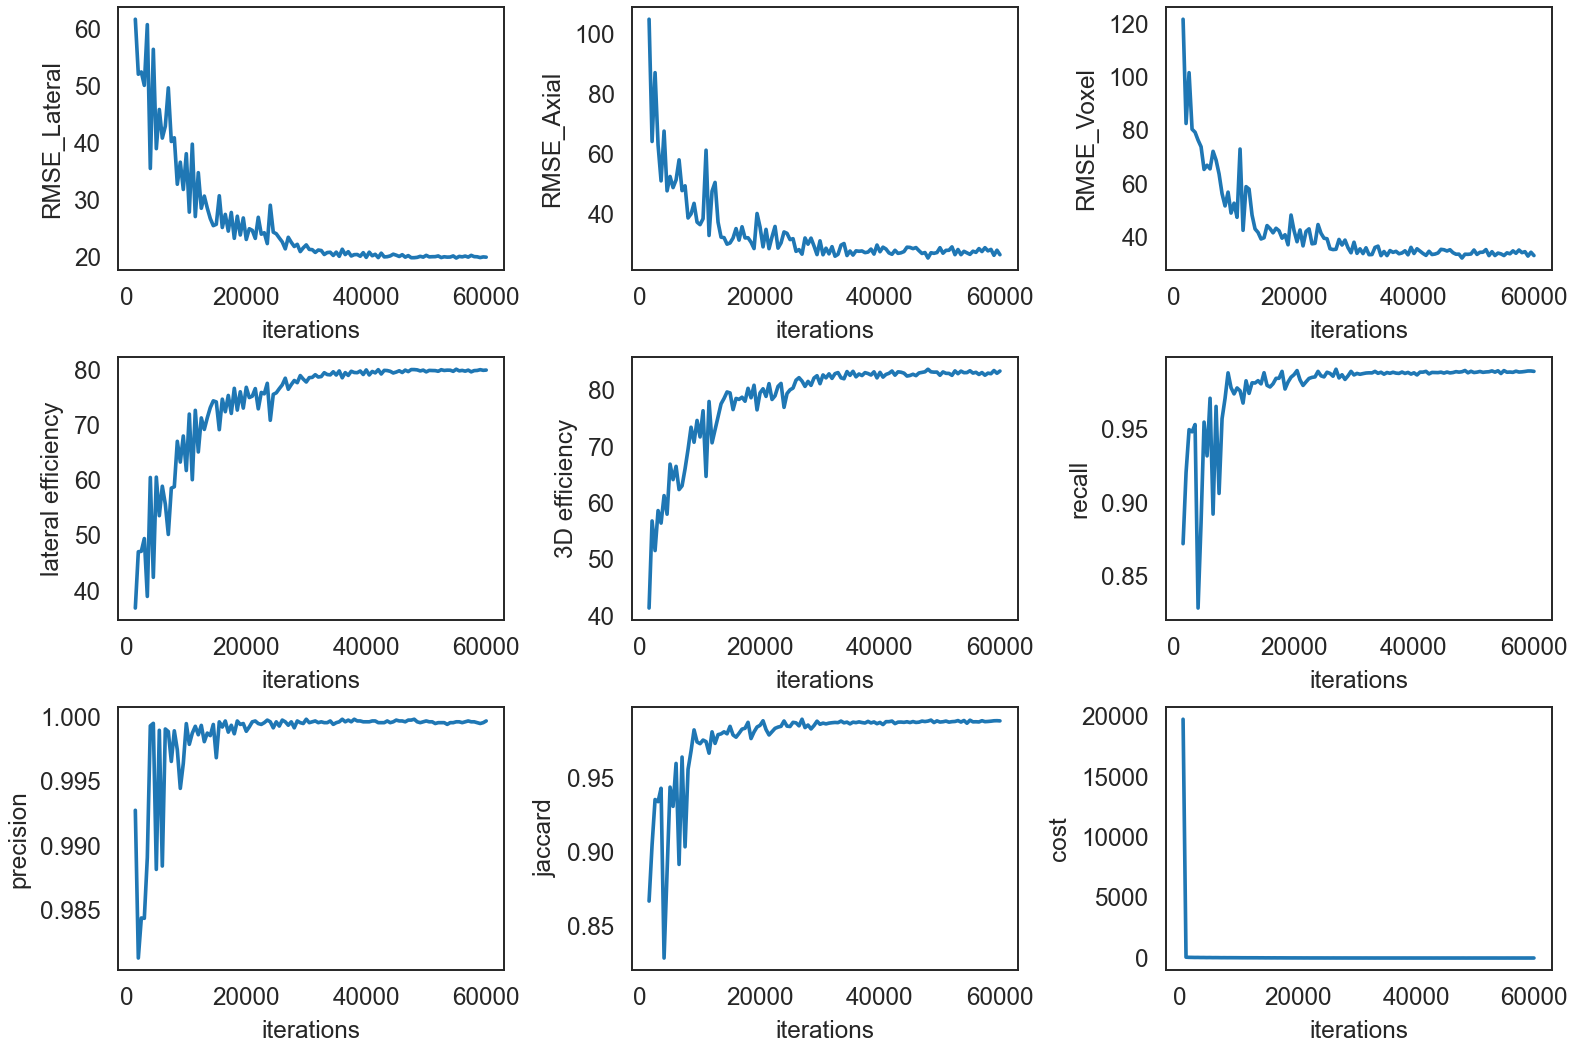

------------------------------------------DECODE model-------------------------------------------


<IPython.core.display.Javascript object>


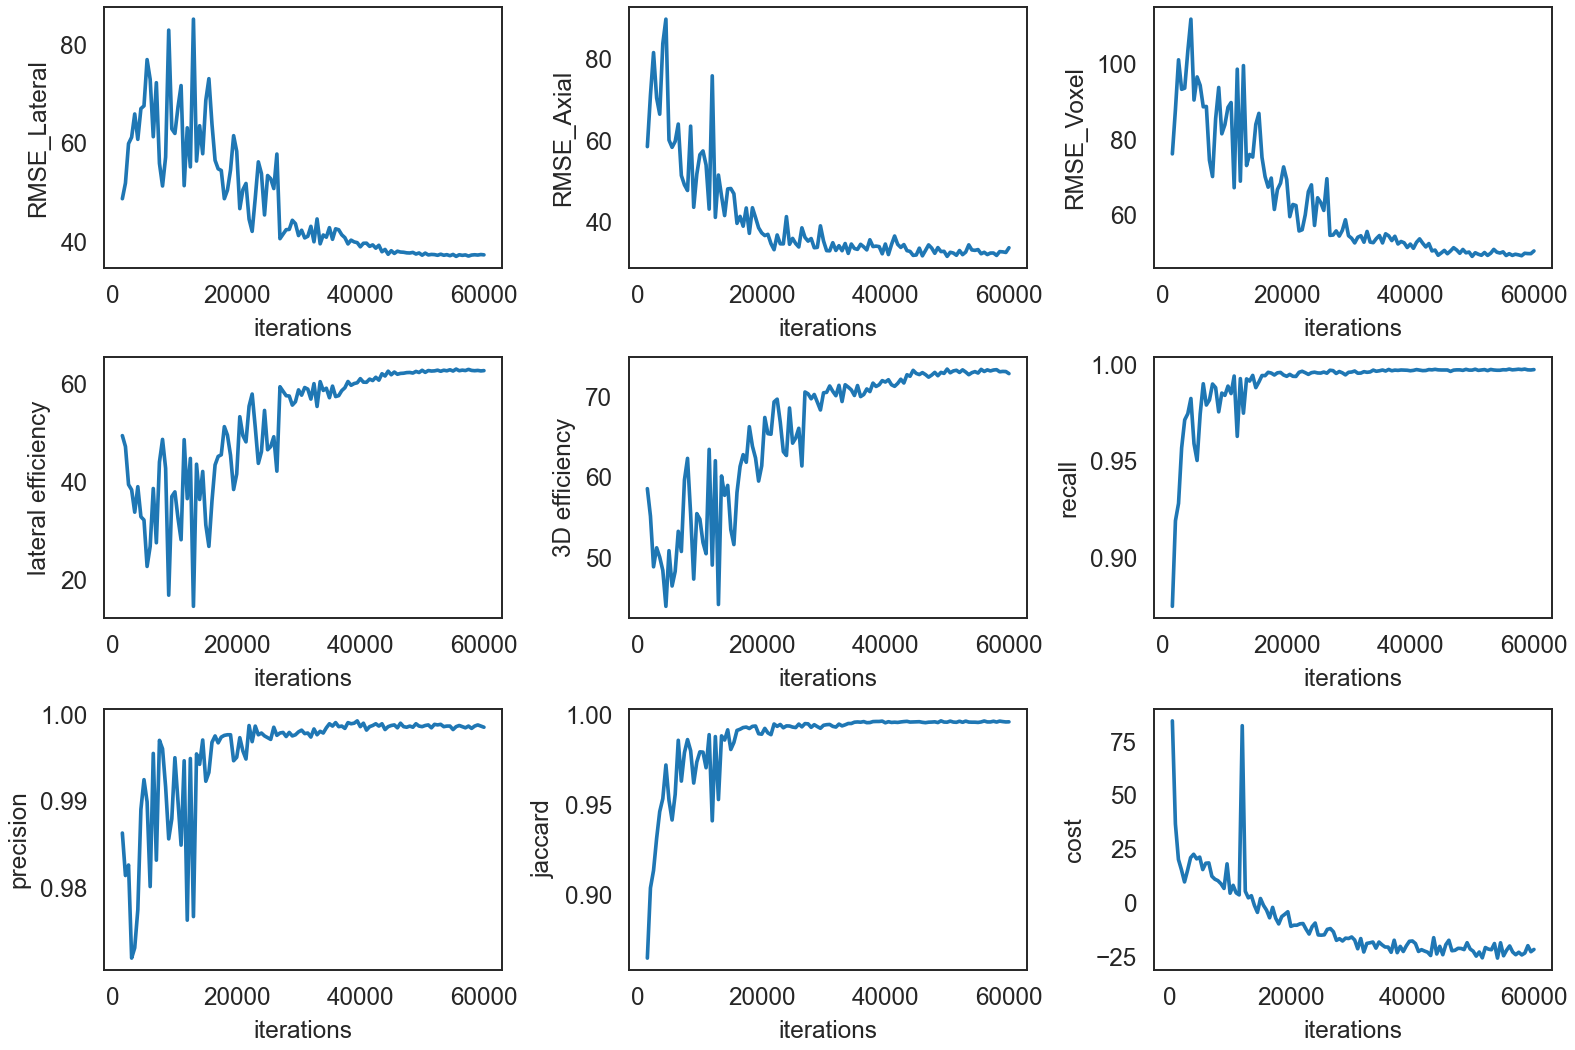

In [3]:
# load the completely trained FD_DECODE model to test or predict
with open(fd_deeploc_path, 'rb') as f:
    fd_deeploc_model = pickle.load(f)
with open(decode_path, 'rb') as f:
    decode_model = pickle.load(f)

# plot performance during the training
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
plot_train_record(fd_deeploc_model)
print('------------------------------------------DECODE model-------------------------------------------')
plot_train_record(decode_model)

## 3. Set necessary parameters.
* `mol_photons` is the average number of signal photons used in training.
* `bg_photons` is the average number of background photons used in training.
* `test_pos` is the global position of the PSF whose CRLB will be computed.
* `Nmol` is the number of sampled z positions, which are uniformly distributed in the training z range.
* `test_num` is the number of simulated random PSFs at each sampled z position for RMSE evaluation, the total number of test set is $testnum*Nmol$.The xy positions for each single emitter are random in the center two pixel, the z position is random in a step range $(zrange/(Nmol-1))$ around each z position.

In [4]:
# set necessary parameters
print(fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape)
bg_photons = (fd_deeploc_model.dat_generator.simulation_pars['backg'] - fd_deeploc_model.dat_generator.simulation_pars['baseline']) \
                     / fd_deeploc_model.dat_generator.simulation_pars['em_gain'] * fd_deeploc_model.dat_generator.simulation_pars['e_per_adu'] \
                     / fd_deeploc_model.dat_generator.simulation_pars['qe']
mol_photons = (fd_deeploc_model.dat_generator.simulation_pars['min_ph'] + 1) / 2 * fd_deeploc_model.dat_generator.psf_pars['ph_scale']
print('{}{}{}{}{}'.format('The average signal/background used for training are: ', int(mol_photons), '/', int(bg_photons), ' photons'))
aber_w = fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape[1]
aber_h = fd_deeploc_model.dat_generator.psf_pars['aber_map'].shape[0]
test_pos_list = [[int(aber_w*0.5), int(aber_h*0.5)],
                 [int(aber_w*0.95), int(aber_h*0.95)]]
print(test_pos_list)

Nmol = 25
test_num = 2000

(2048, 2048, 23)
The average signal/background used for training are: 4998/49 photons
[[1024, 1024], [1945, 1945]]


## 4. Check the CRLB of a local PSF at given position.
* `model` is the FD-DeepLoc model.
* `test_pos` is the global position where the PSF CRLB will be computed and checked.
* `test_photons` is the number of signal photons used to compute CRLB.
* `test_bg` is the number of background photons used to compute CRLB.
* `Nmol` is the number of sampled z positions, which are uniformly distributed in the training z range.

------------------------------------------FD-DeepLoc model-------------------------------------------


D:\Softwares\anaconda\envs\fd_deeploc\lib\site-packages\torch\functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ..\aten\src\ATen\native\TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


look PSF model at this position [1024, 1024]


<IPython.core.display.Javascript object>


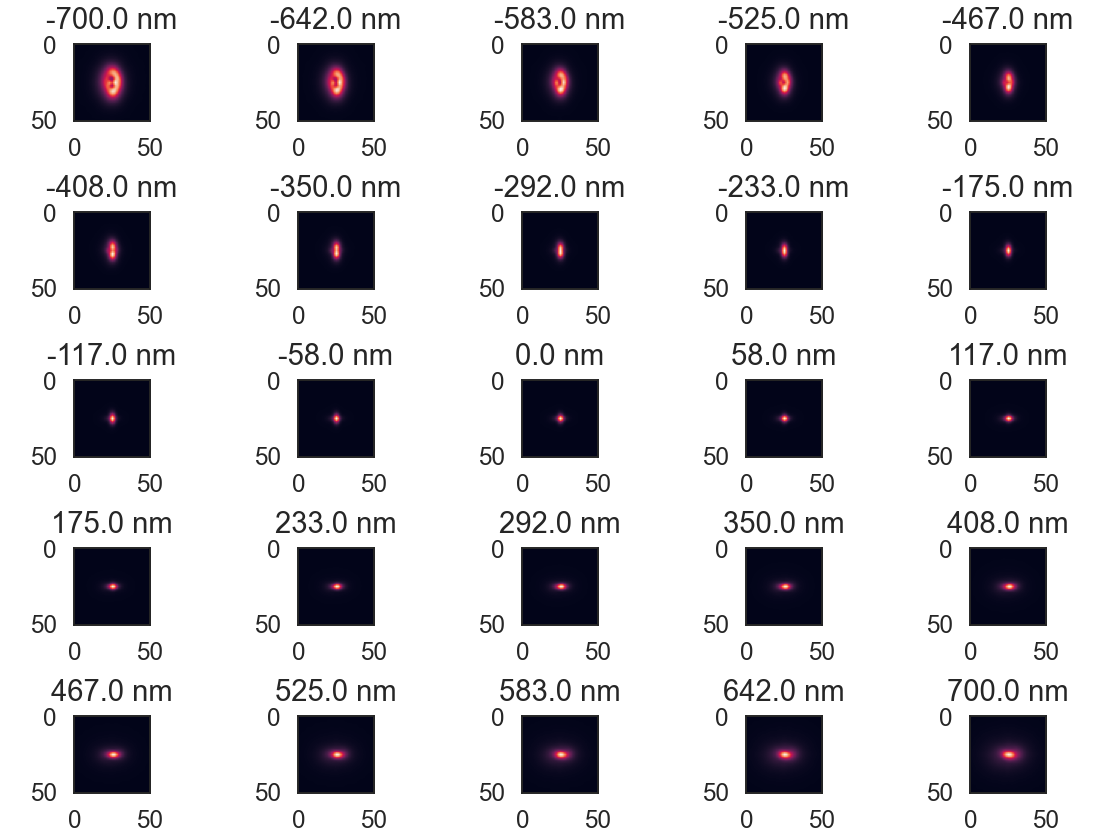

average 3D CRLB is: 757.80625


<IPython.core.display.Javascript object>


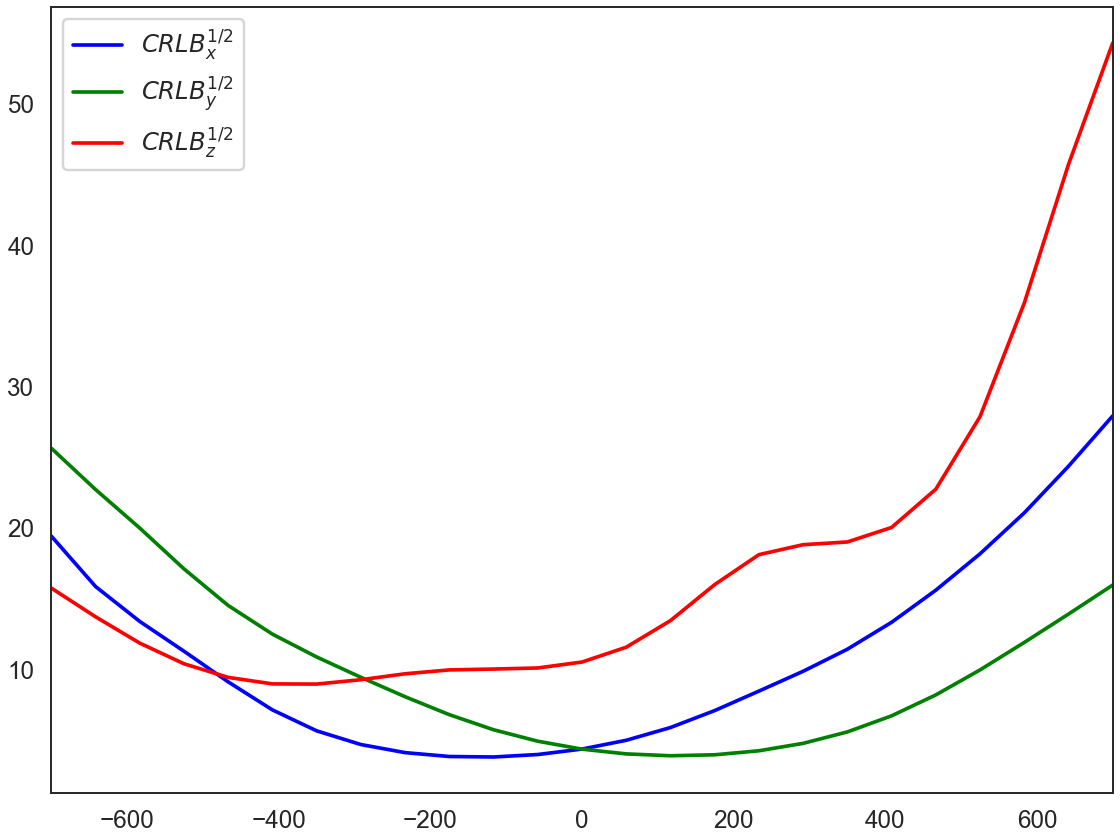

In [5]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
check_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol)
# print('------------------------------------------DECODE model-------------------------------------------')
# check_local_CRLB(model=decode_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol)

## 5. Compare network's performance with local single-emitter CRLB.
* `use_train_cam`: If true, the single-emitter test set will be simulated using the camera noise of training (e.g., qe, readout noise, analog-to-digital conversion factor). Otherwise only poisson noise will be added.
* `test_num` is the number of simulated random PSFs at each sampled z position for RMSE evaluation, the total number of test set is $testnum*Nmol$.The xy positions for each single emitter are random in the center two pixel, the z position is random in a step range $(zrange/(Nmol-1))$ around each z position.
* The remaining is the same as above.

------------------------------------------FD-DeepLoc model-------------------------------------------
compare with PSF CRLB at this position [1024, 1024]
average 3D CRLB is: 757.80625
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


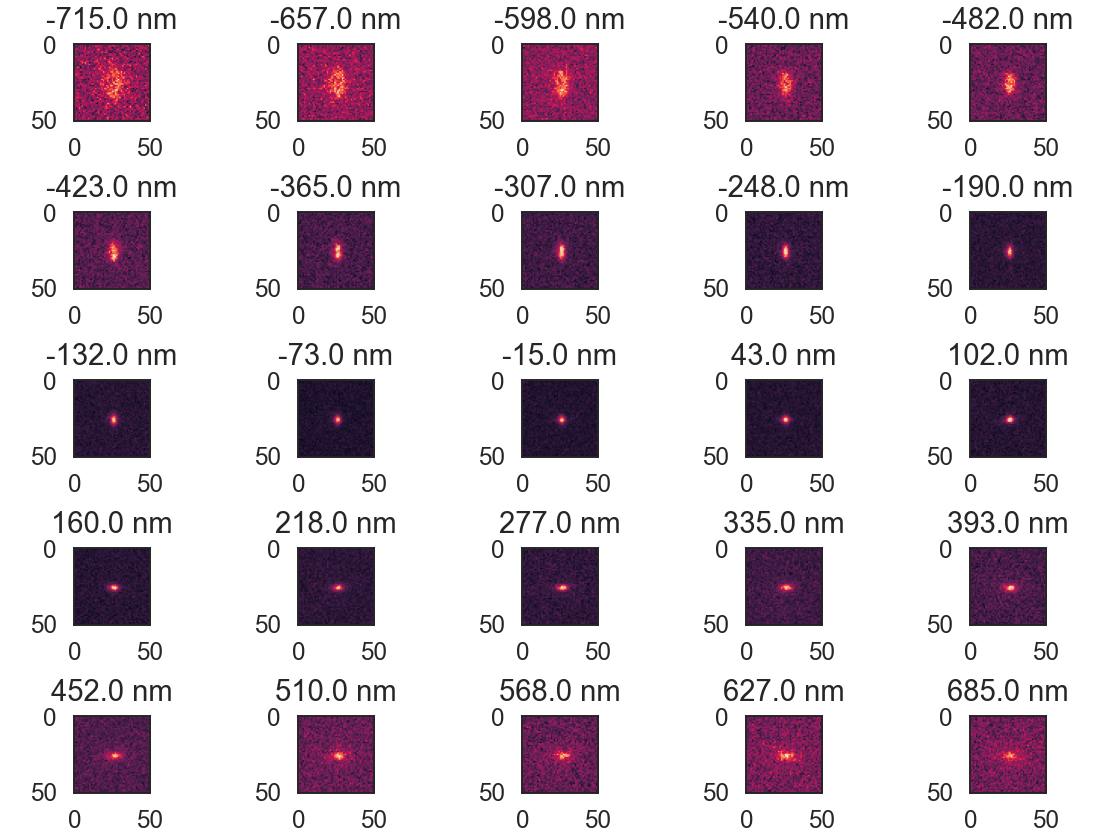

start inferring
field_xy: [ 998. 1049.  998. 1049.] , use_coordconv: True , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:59<00:00, 104.92it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49589
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49589
Recall: 0.992
Precision: 1.000
Jaccard: 99.178
RMSE_lat: 18.862
RMSE_ax: 22.724
RMSE_vol: 29.533
Jaccard/RMSE: 5.258
Eff_lat: 81.120
Eff_ax: 88.608
Eff_3d: 84.864
FN: 411.0 FP: 0.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


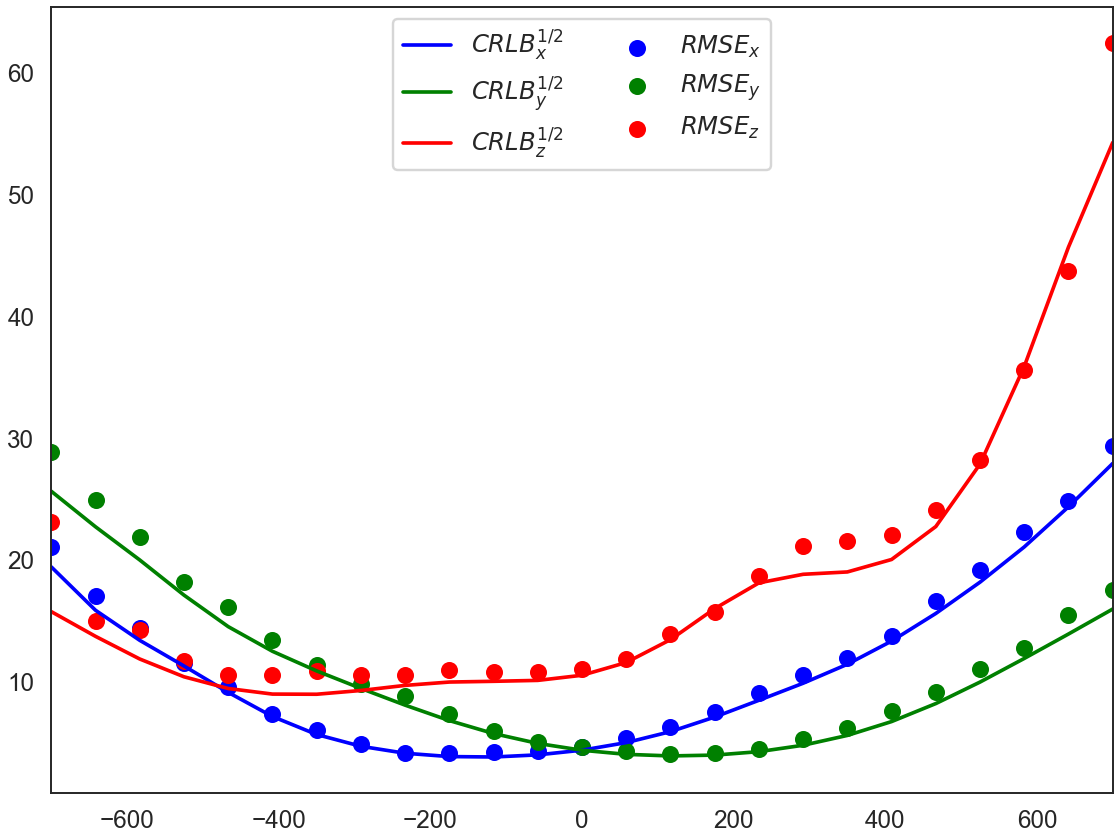

------------------------------------------DECODE model-------------------------------------------
compare with PSF CRLB at this position [1024, 1024]
average 3D CRLB is: 757.80625
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


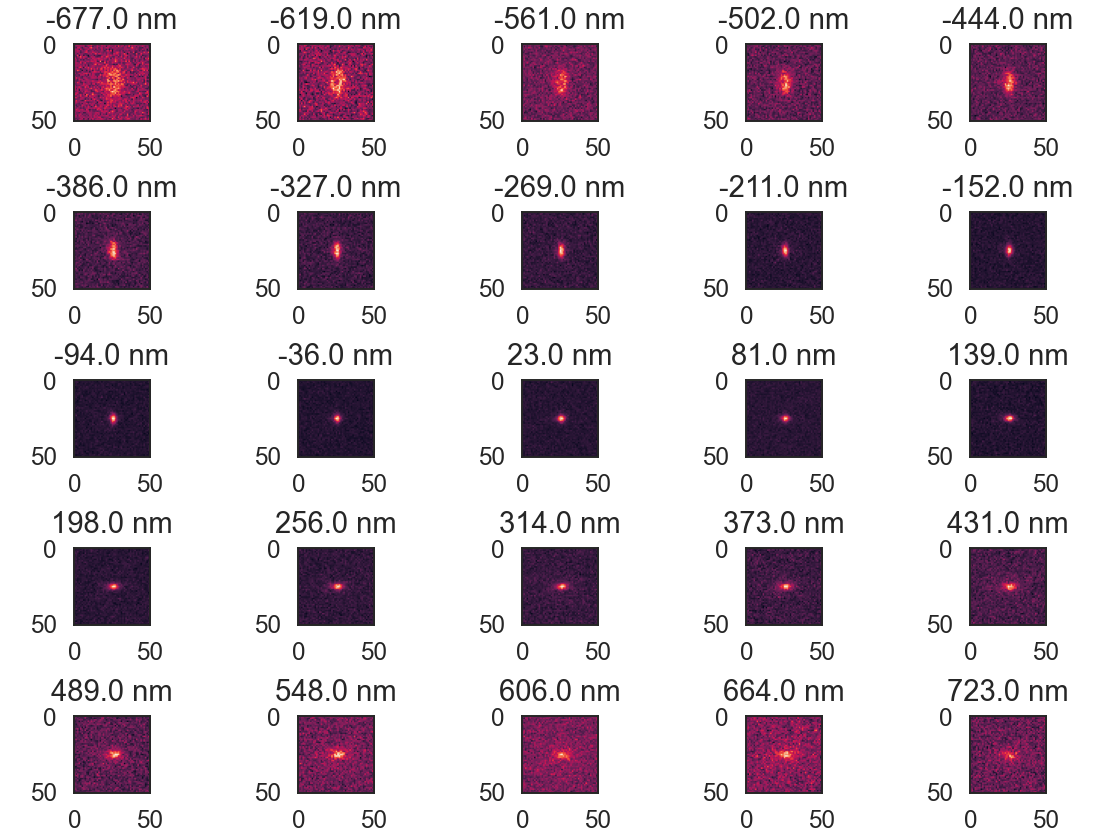

start inferring
field_xy: [ 998. 1049.  998. 1049.] , use_coordconv: False , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:15<00:00, 165.24it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49987
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49987
Recall: 1.000
Precision: 1.000
Jaccard: 99.946
RMSE_lat: 28.433
RMSE_ax: 26.076
RMSE_vol: 38.580
Jaccard/RMSE: 3.515
Eff_lat: 71.567
Eff_ax: 86.962
Eff_3d: 79.264
FN: 20.0 FP: 7.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


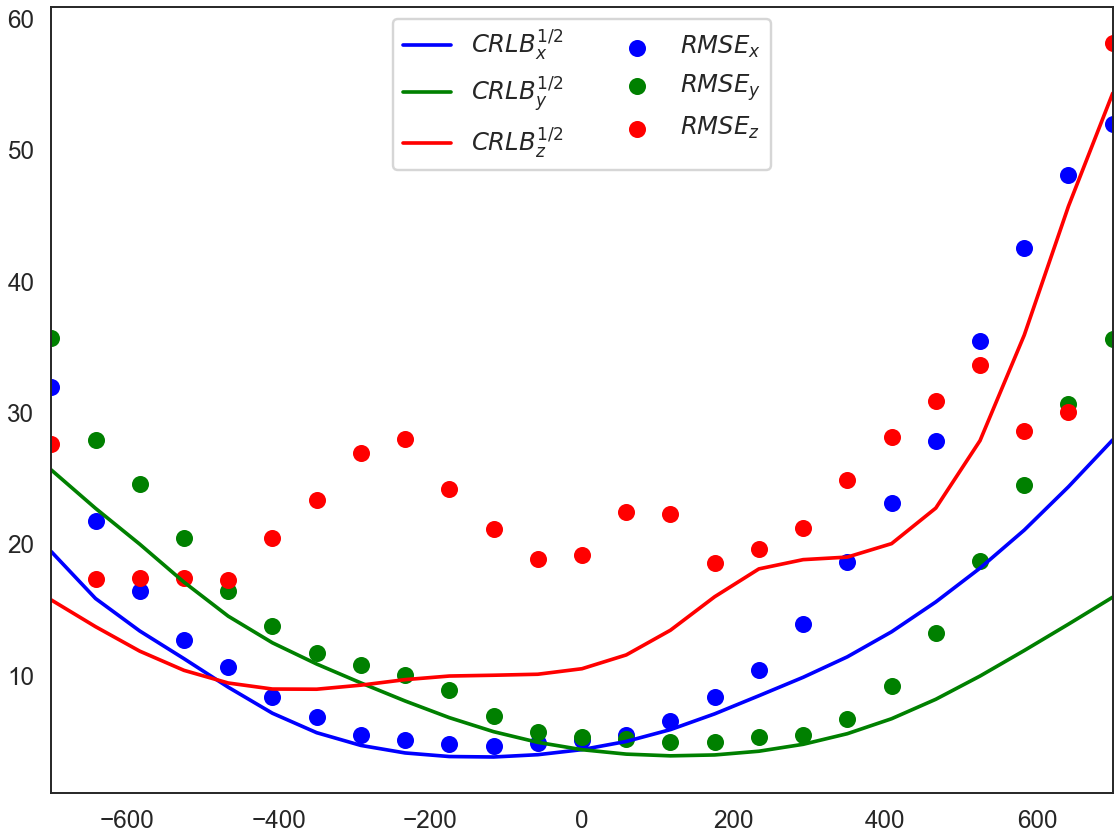

<IPython.core.display.Javascript object>


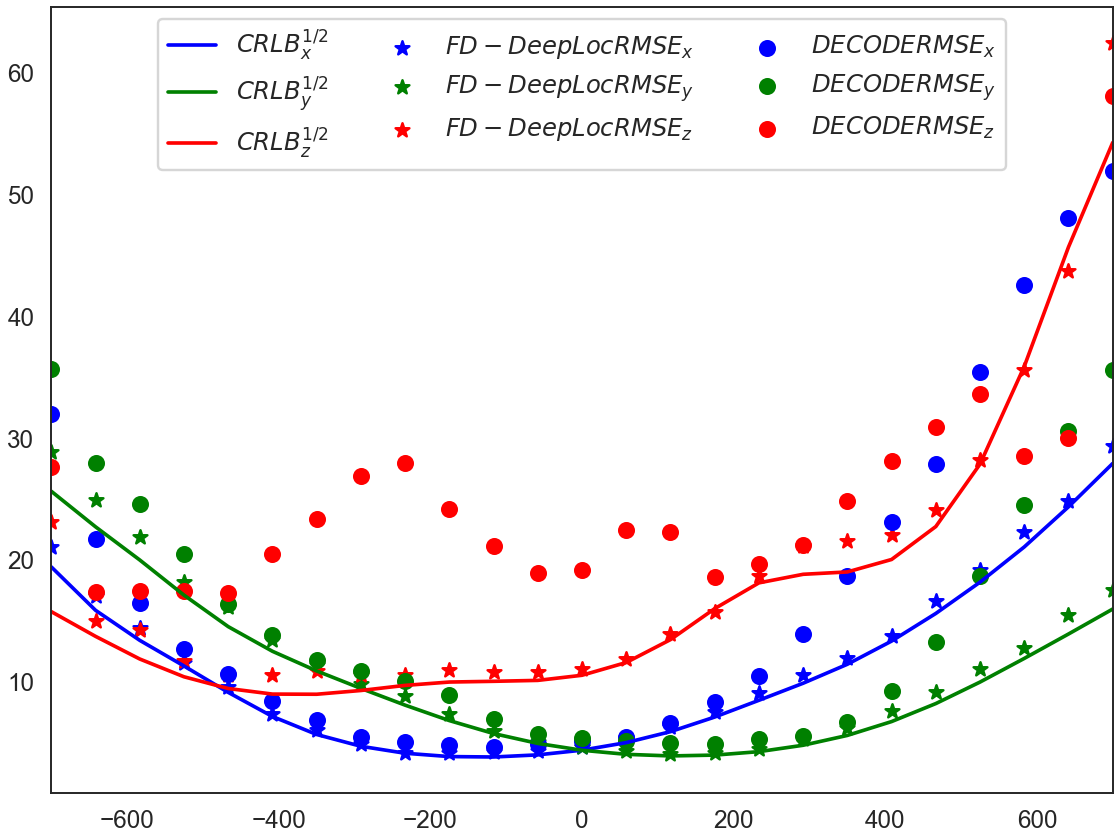

In [6]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_fd_deeploc = test_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)
print('------------------------------------------DECODE model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_decode = test_local_CRLB(model=decode_model, test_pos=test_pos_list[0], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)

# compare directly
plt.figure(constrained_layout=True)
plt.plot(zpos, x_crlb,'b', zpos, y_crlb,'g', zpos, z_crlb,'r')
plt.scatter(zpos, rmse_xyz_fd_deeploc[0, :],c="b",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[1, :],c="g",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[2, :],c="r",marker="*")
plt.scatter(zpos, rmse_xyz_decode[0, :],c="b",marker="o")
plt.scatter(zpos, rmse_xyz_decode[1, :],c="g",marker="o")
plt.scatter(zpos, rmse_xyz_decode[2, :],c="r",marker="o")
plt.legend(('$CRLB_x^{1/2}$', '$CRLB_y^{1/2}$', '$CRLB_z^{1/2}$', 
            '$FD-DeepLoc RMSE_x$', '$FD-DeepLoc RMSE_y$', '$FD-DeepLoc RMSE_z$', 
            '$DECODE RMSE_x$', '$DECODE RMSE_y$', '$DECODE RMSE_z$'), ncol=3,
           loc='upper center')
plt.xlim([np.min(zpos), np.max(zpos)])
plt.show()

------------------------------------------FD-DeepLoc model-------------------------------------------
compare with PSF CRLB at this position [1945, 1945]
average 3D CRLB is: 644.046640625
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


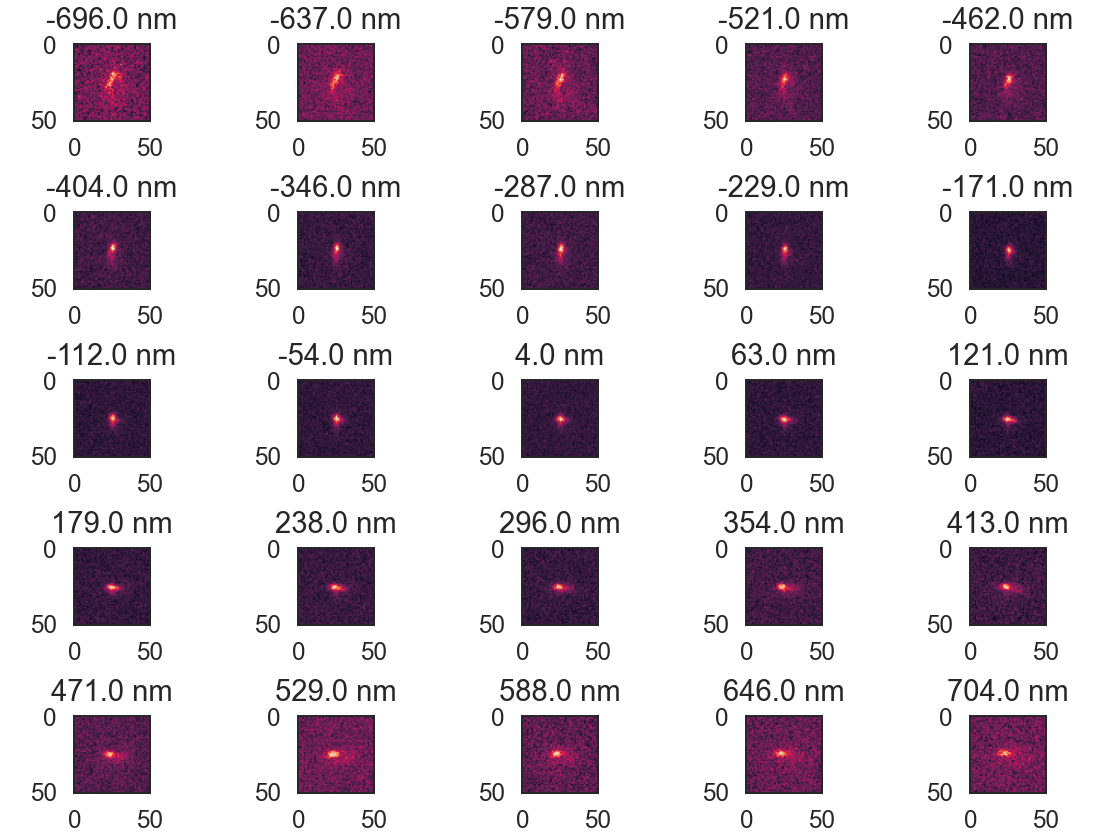

start inferring
field_xy: [1919. 1970. 1919. 1970.] , use_coordconv: True , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:59<00:00, 104.30it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:49453
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 49453
Recall: 0.989
Precision: 1.000
Jaccard: 98.906
RMSE_lat: 19.518
RMSE_ax: 22.586
RMSE_vol: 29.851
Jaccard/RMSE: 5.067
Eff_lat: 80.451
Eff_ax: 88.654
Eff_3d: 84.553
FN: 547.0 FP: 0.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


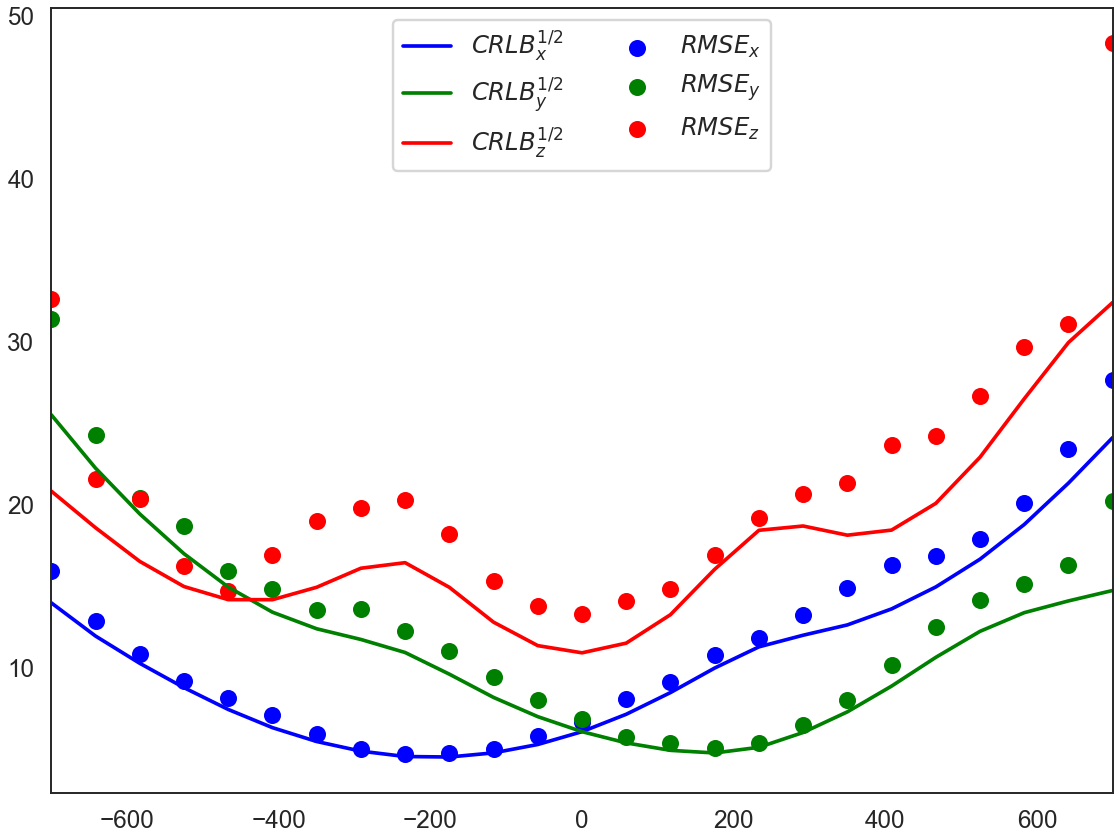

------------------------------------------DECODE model-------------------------------------------
compare with PSF CRLB at this position [1945, 1945]
average 3D CRLB is: 644.046640625
simulating single-emitter images for CRLB test
simulated 50000/50000 images

example single-emitter data for CRLB test


<IPython.core.display.Javascript object>


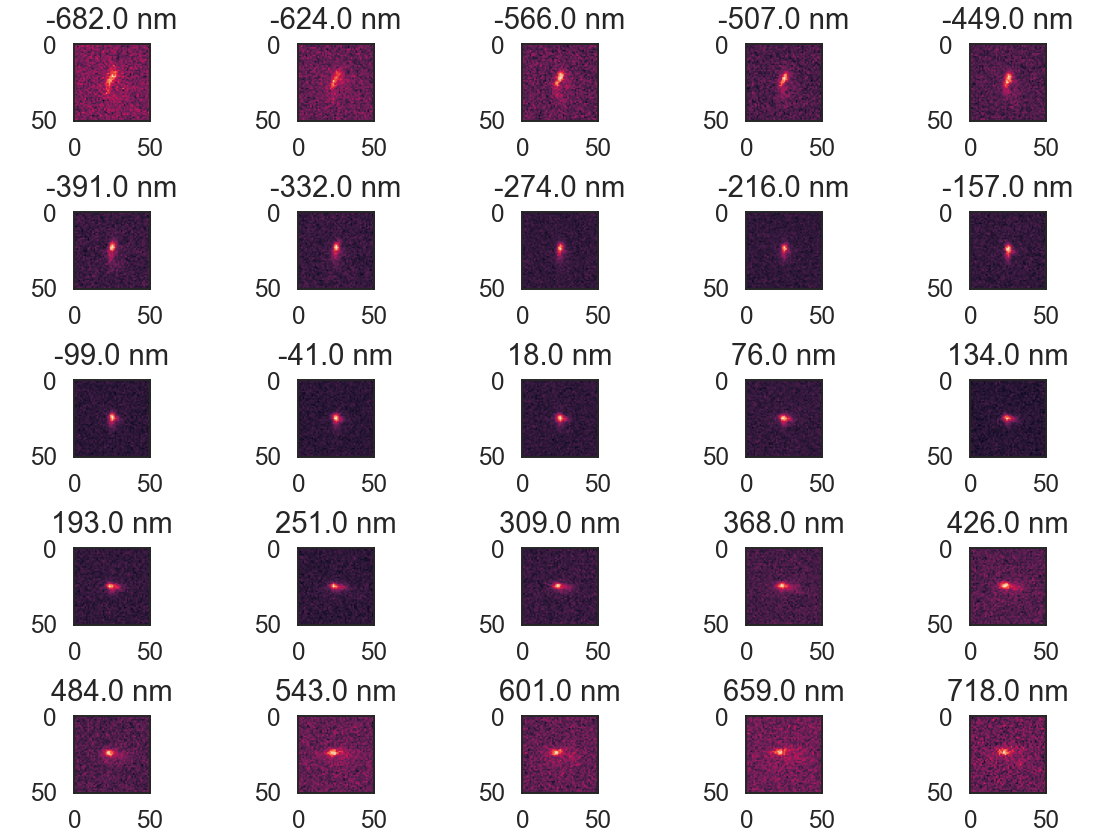

start inferring
field_xy: [1919. 1970. 1919. 1970.] , use_coordconv: False , aber_map_size: (2048, 2048, 23)


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [01:15<00:00, 166.40it/s]


start computing evaluation metrics

evaluation on 50000 images, contain ground truth: 50000, preds:50004
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 50000 ,preds: 50004
Recall: 0.995
Precision: 0.995
Jaccard: 99.009
RMSE_lat: 75.194
RMSE_ax: 33.814
RMSE_vol: 82.447
Jaccard/RMSE: 1.317
Eff_lat: 24.800
Eff_ax: 83.064
Eff_3d: 53.932
FN: 247.0 FP: 251.0
plot the RMSE of network prediction vs CRLB


<IPython.core.display.Javascript object>


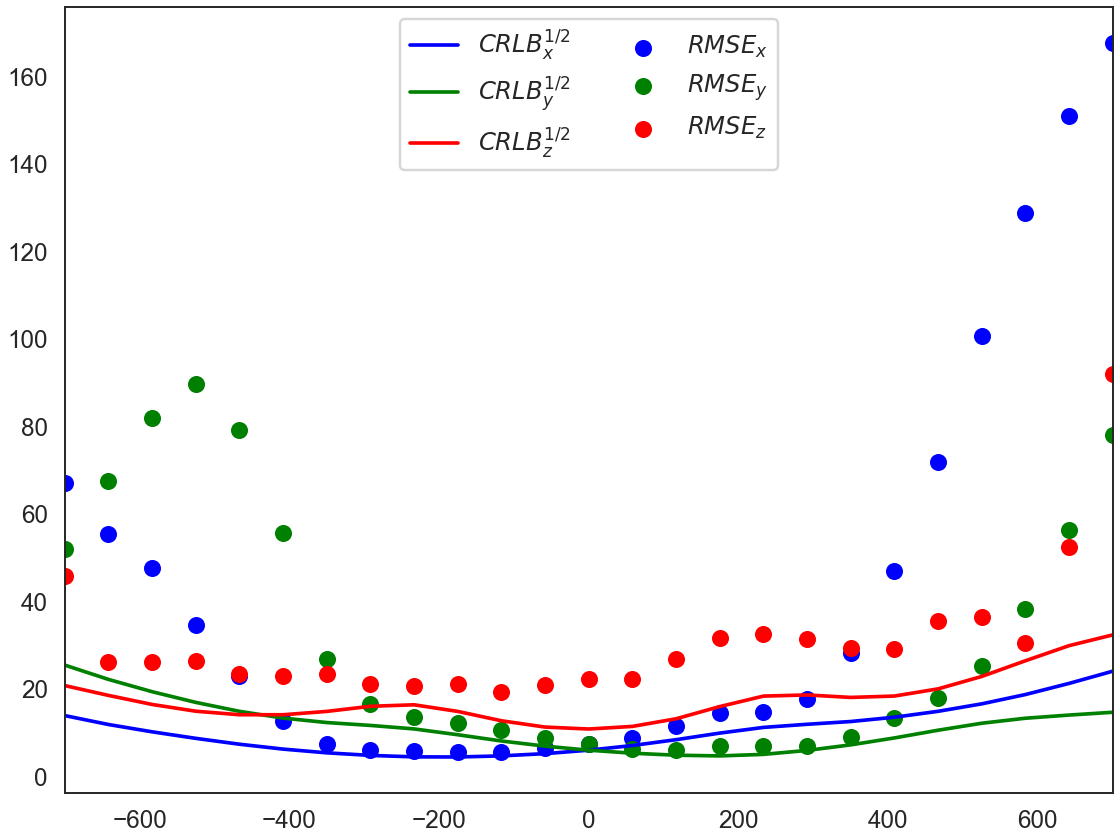

<IPython.core.display.Javascript object>


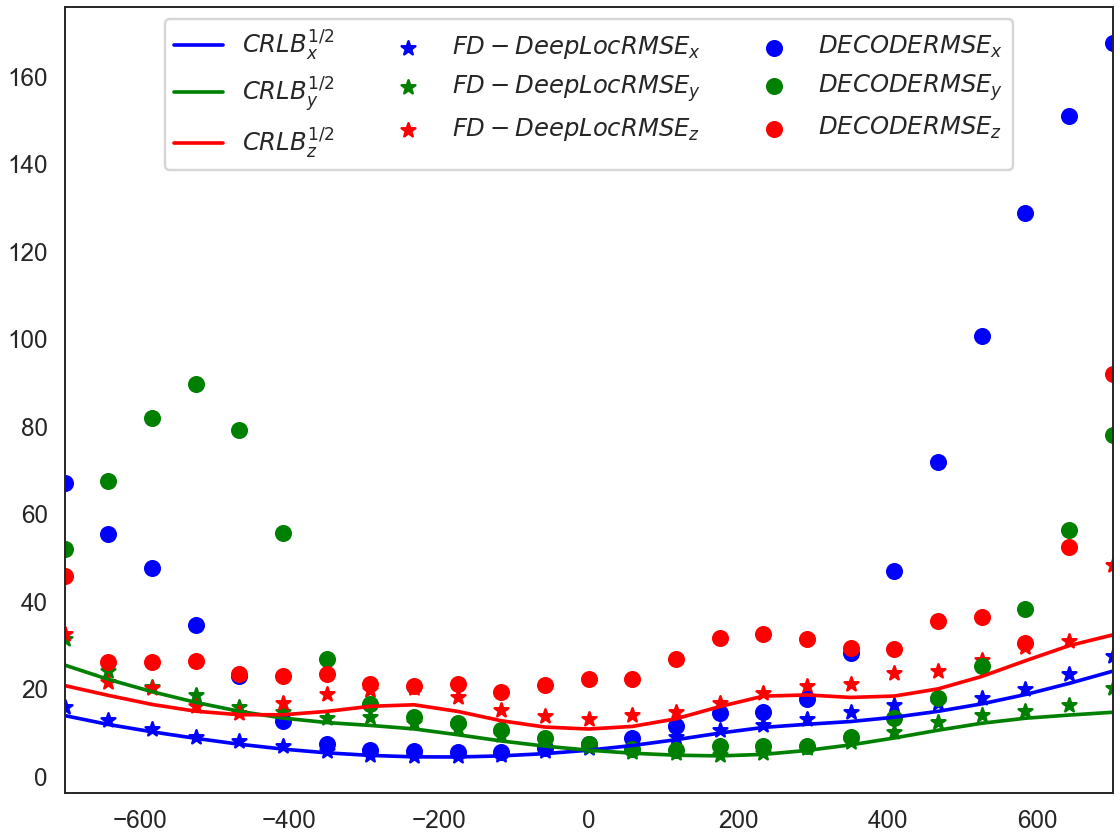

In [7]:
print('------------------------------------------FD-DeepLoc model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_fd_deeploc = test_local_CRLB(model=fd_deeploc_model, test_pos=test_pos_list[1], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)
print('------------------------------------------DECODE model-------------------------------------------')
zpos, x_crlb, y_crlb, z_crlb, rmse_xyz_decode = test_local_CRLB(model=decode_model, test_pos=test_pos_list[1], test_photons=mol_photons, test_bg=bg_photons, Nmol=Nmol,
                use_train_cam=True, test_num=test_num, show_res=True)

# compare directly
plt.figure(constrained_layout=True)
plt.plot(zpos, x_crlb,'b', zpos, y_crlb,'g', zpos, z_crlb,'r')
plt.scatter(zpos, rmse_xyz_fd_deeploc[0, :],c="b",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[1, :],c="g",marker="*")
plt.scatter(zpos, rmse_xyz_fd_deeploc[2, :],c="r",marker="*")
plt.scatter(zpos, rmse_xyz_decode[0, :],c="b",marker="o")
plt.scatter(zpos, rmse_xyz_decode[1, :],c="g",marker="o")
plt.scatter(zpos, rmse_xyz_decode[2, :],c="r",marker="o")
plt.legend(('$CRLB_x^{1/2}$', '$CRLB_y^{1/2}$', '$CRLB_z^{1/2}$', 
            '$FD-DeepLoc RMSE_x$', '$FD-DeepLoc RMSE_y$', '$FD-DeepLoc RMSE_z$', 
            '$DECODE RMSE_x$', '$DECODE RMSE_y$', '$DECODE RMSE_z$'), ncol=3,
           loc='upper center')
plt.xlim([np.min(zpos), np.max(zpos)])
plt.show()

## 6. Start inferring on dataset
* `stack_giga` is the size of sequentially processed images (in gigabyte), it is only an approximate value, set it small when you have limited RAM.
* `pixel_size` is the physical size of each camera pixel (_xy_ in nm).
* `start_field_pos`: **Important**, it is the **_xy_** position of the upper left pixel of the input images in the entire FOV. For example, `start_field_pos` [102,41] means the upper left pixel (namely local position [0,0]) of the input images is located at [102,41] of the whole FOV. Thus CoordConv can get the global position of the input images.

Read big tiff and predict, save the predictions every finish processing `stack_giga`-sized SMLM images, even some accidents happen you will not lose all results. If there is already a prediction file with the same name as `save_path`, inference will start from the last saved frame number in the `save_path` file. We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) and render the super-resolution image (Ries, J. SMAP: a modular super-resolution microscopy analysis platform for SMLM data. Nat Methods 17, 870–872 (2020). https://doi.org/10.1038/s41592-020-0938-1). 
* The parameters haven been explained before.

In [8]:
# set the size of file to be processed sequentially, unit: gigabyte
stack_giga = 0.5
pixel_size = [100, 100]
start_field_pos = [0, 0]

print('------------------------------------------FD-DeepLoc model-------------------------------------------')
# read big tiff and predict, save the predictions every finish processing stack_giga-sized SMLM images,
# even some accidents happen you will not lose all results
total_shape,fov_size = read_bigtiff_and_predict(fd_deeploc_model, image_path, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=fd_deeploc_save_path)

print('------------------------------------------DECODE model-------------------------------------------')
total_shape,fov_size = read_bigtiff_and_predict(decode_model, image_path, stack_giga=stack_giga, batch_size=10,
                                                use_tqdm=True, nms=True, candi_thre=0.3, nms_thre=0.3,
                                                rescale_xy=False, pixel_size=pixel_size, start_field_pos=start_field_pos, 
                                                divide_and_conquer=True, win_size=256, padding=True, save_path=decode_save_path)

------------------------------------------FD-DeepLoc model-------------------------------------------
the file to save the predictions is:  ./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
stack: 1/33, contain imgs: 62, already analyzed:0/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.61it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.19it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



stack: 2/33, contain imgs: 62, already analyzed:62/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.88it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.95it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.45it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.04it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.79it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.56it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.41it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.70it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.11it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.09it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.14it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.79it/s]



stack: 3/33, contain imgs: 62, already analyzed:124/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.02it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.70it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.71it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.70it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.16it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.61it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.70it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.23it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.72it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.72it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.62it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.63it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.25it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.62it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.11it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.11it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.10it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.81it/s]



stack: 4/33, contain imgs: 62, already analyzed:186/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.37it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.25it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.22it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.16it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.69it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.12it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.66it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.67it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.74it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.87it/s]



stack: 5/33, contain imgs: 62, already analyzed:248/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.90it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.78it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.86it/s]



stack: 6/33, contain imgs: 62, already analyzed:310/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.86it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.86it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.76it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.28it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.79it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



stack: 7/33, contain imgs: 62, already analyzed:372/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.29it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.87it/s]



stack: 8/33, contain imgs: 62, already analyzed:434/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.06it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.57it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.17it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.82it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.14it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.77it/s]



stack: 9/33, contain imgs: 62, already analyzed:496/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.08it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.78it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.87it/s]



stack: 10/33, contain imgs: 62, already analyzed:558/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.07it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.17it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.02it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.85it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



stack: 11/33, contain imgs: 62, already analyzed:620/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.26it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.85it/s]



stack: 12/33, contain imgs: 62, already analyzed:682/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.38it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.21it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.25it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]



stack: 13/33, contain imgs: 62, already analyzed:744/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.86it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.28it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



stack: 14/33, contain imgs: 62, already analyzed:806/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.95it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.66it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



stack: 15/33, contain imgs: 62, already analyzed:868/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.23it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.00it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.02it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



stack: 16/33, contain imgs: 62, already analyzed:930/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.93it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.96it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



stack: 17/33, contain imgs: 62, already analyzed:992/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.85it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.97it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.02it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.87it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



stack: 18/33, contain imgs: 62, already analyzed:1054/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.59it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.21it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.66it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.71it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.76it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.62it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.58it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.07it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.64it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.26it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.15it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.08it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.15it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



stack: 19/33, contain imgs: 62, already analyzed:1116/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.07it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.13it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.67it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.14it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.70it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.20it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.72it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.64it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.72it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.72it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.25it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.00it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



stack: 20/33, contain imgs: 62, already analyzed:1178/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.88it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.96it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



stack: 21/33, contain imgs: 62, already analyzed:1240/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.74it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.66it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.28it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.17it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.74it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.70it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.97it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.23it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.06it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.09it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.82it/s]



stack: 22/33, contain imgs: 62, already analyzed:1302/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.10it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.17it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.78it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.66it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.28it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.01it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.78it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.23it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.79it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.71it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



stack: 23/33, contain imgs: 62, already analyzed:1364/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.12it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.99it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.06it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.53it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.71it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.75it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.68it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.46it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.64it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.70it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.13it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.23it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.07it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.76it/s]



stack: 24/33, contain imgs: 62, already analyzed:1426/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.44it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.03it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.30it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.74it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.02it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



stack: 25/33, contain imgs: 62, already analyzed:1488/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  5.97it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.95it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.02it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.92it/s]



stack: 26/33, contain imgs: 62, already analyzed:1550/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.28it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.98it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.91it/s]



stack: 27/33, contain imgs: 62, already analyzed:1612/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.67it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.52it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.98it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.86it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.86it/s]



stack: 28/33, contain imgs: 62, already analyzed:1674/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.25it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.52it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.00it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  7.00it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.90it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



stack: 29/33, contain imgs: 62, already analyzed:1736/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.63it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.96it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.82it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.86it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.87it/s]



stack: 30/33, contain imgs: 62, already analyzed:1798/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.19it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.51it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.98it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.01it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.47it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.80it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.89it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.93it/s]



stack: 31/33, contain imgs: 62, already analyzed:1860/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.55it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.49it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.97it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.46it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.98it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.99it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.36it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.61it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.73it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.17it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.69it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.64it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.90it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.77it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.27it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.84it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.81it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.32it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.34it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.37it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.84it/s]



stack: 32/33, contain imgs: 62, already analyzed:1922/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.29it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.40it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.43it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.97it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.92it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.94it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.39it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.95it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.96it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.83it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.88it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.91it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.86it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.85it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.93it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.87it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:01<00:00,  6.89it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.38it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.83it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.31it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.35it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.33it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.80it/s]



stack: 33/33, contain imgs: 16, already analyzed:1984/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:True, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  4.89it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:True, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.88it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:True, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.95it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:True, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:True, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.12it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:True, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.98it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:True, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.06it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:True, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.65it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:True, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.92it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:True, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:True, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:True, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:True, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:True, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:True, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:True, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.75it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:True, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:True, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:True, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.37it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:True, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:True, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:True, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:True, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.39it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:True, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:True, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:True, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:True, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:True, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:True, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.37it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:True, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:True, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:True, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:True, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:True, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.19it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:True, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.22it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:True, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.32it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:True, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.36it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:True, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:True, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:True, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:True, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:True, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.42it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:True, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.31it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:True, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.40it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:True, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:True, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:True, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:True, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.93it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:True, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.96it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:True, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.30it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:True, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.35it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:True, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.43it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:True, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:True, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.38it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:True, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.24it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:True, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.76it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:True, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.47it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:True, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.90it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:True, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:True, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:True, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.87it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:True, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.99it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:True, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.84it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:True, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.40it/s]



analysis finished ! the file containing results is: ./demo1_FD-DeepLoc_sim_data_normal_aberration_medium_SNR.csv
------------------------------------------DECODE model-------------------------------------------
the file to save the predictions is:  ./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv
stack: 1/33, contain imgs: 62, already analyzed:0/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.29it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.18it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.02it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.47it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.87it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.88it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.03it/s]



stack: 2/33, contain imgs: 62, already analyzed:62/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.24it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.09it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.94it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.47it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.05it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.11it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.02it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.57it/s]



stack: 3/33, contain imgs: 62, already analyzed:124/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.25it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.10it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.40it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.18it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.41it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.51it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.00it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.02it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13it/s]



stack: 4/33, contain imgs: 62, already analyzed:186/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.53it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.18it/s]



stack: 5/33, contain imgs: 62, already analyzed:248/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.74it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.12it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.27it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.06it/s]



stack: 6/33, contain imgs: 62, already analyzed:310/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.75it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.47it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.13it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.48it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.18it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.23it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.44it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.35it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.12it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.46it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.16it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.15it/s]



stack: 7/33, contain imgs: 62, already analyzed:372/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.01it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.18it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.20it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.32it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.02it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



stack: 8/33, contain imgs: 62, already analyzed:434/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.44it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.04it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



stack: 9/33, contain imgs: 62, already analyzed:496/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.41it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.08it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.94it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.35it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.46it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.22it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.99it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.34it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.37it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



stack: 10/33, contain imgs: 62, already analyzed:558/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.64it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.26it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.93it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.48it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.40it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.45it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.43it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.51it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.27it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.12it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.35it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.11it/s]



stack: 11/33, contain imgs: 62, already analyzed:620/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.05it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.95it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.12it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.02it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.44it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.11it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.00it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.28it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.13it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.87it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.21it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.39it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.22it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.43it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.27it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.87it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.14it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.89it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.56it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.50it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.60it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.59it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.09it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.60it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.15it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.70it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.04it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



stack: 12/33, contain imgs: 62, already analyzed:682/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.74it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.15it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13it/s]



stack: 13/33, contain imgs: 62, already analyzed:744/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.16it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.10it/s]



stack: 14/33, contain imgs: 62, already analyzed:806/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.87it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.22it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.40it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.24it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.18it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.15it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.45it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.13it/s]



stack: 15/33, contain imgs: 62, already analyzed:868/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.44it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.20it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.02it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.40it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.08it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.01it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.39it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.01it/s]



stack: 16/33, contain imgs: 62, already analyzed:930/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.77it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.01it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.47it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.47it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.27it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.49it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.64it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.98it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.08it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.14it/s]



stack: 17/33, contain imgs: 62, already analyzed:992/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.58it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.96it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.20it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.06it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.19it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.60it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.51it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.91it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.68it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.23it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.41it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.31it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.40it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.46it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.55it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.98it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.09it/s]



stack: 18/33, contain imgs: 62, already analyzed:1054/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.58it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.38it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.08it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.49it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.45it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.16it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.06it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.29it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.16it/s]



stack: 19/33, contain imgs: 62, already analyzed:1116/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.06it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.18it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.94it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.25it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.46it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.69it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.66it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.36it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.53it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.04it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.01it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.27it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.01it/s]



stack: 20/33, contain imgs: 62, already analyzed:1178/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.88it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.34it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.33it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.35it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.84it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.09it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.60it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.39it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.38it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.54it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.48it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.30it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.31it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.24it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.58it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.97it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.21it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.59it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.25it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.76it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.05it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.50it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.56it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.52it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.35it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.03it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.99it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.36it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.63it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.62it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.61it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.07it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.06it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.22it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.96it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.57it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.67it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.28it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.18it/s]



stack: 21/33, contain imgs: 62, already analyzed:1240/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.57it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.18it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.41it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.13it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.65it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.55it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.26it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.55it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.24it/s]



stack: 22/33, contain imgs: 62, already analyzed:1302/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.17it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.26it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.40it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.70it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.22it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]



stack: 23/33, contain imgs: 62, already analyzed:1364/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.22it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.55it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.20it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.24it/s]



stack: 24/33, contain imgs: 62, already analyzed:1426/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.48it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.56it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.56it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.44it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.86it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



stack: 25/33, contain imgs: 62, already analyzed:1488/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.41it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.24it/s]



stack: 26/33, contain imgs: 62, already analyzed:1550/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.60it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.55it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.24it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.37it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.20it/s]



stack: 27/33, contain imgs: 62, already analyzed:1612/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.84it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.22it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.21it/s]



stack: 28/33, contain imgs: 62, already analyzed:1674/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.50it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.57it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.22it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



stack: 29/33, contain imgs: 62, already analyzed:1736/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.35it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.55it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.27it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.22it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.25it/s]



stack: 30/33, contain imgs: 62, already analyzed:1798/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  8.27it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.43it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.56it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.42it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.84it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.26it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.22it/s]



stack: 31/33, contain imgs: 62, already analyzed:1860/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.45it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.56it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.26it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.77it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.73it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.76it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.49it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.54it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



stack: 32/33, contain imgs: 62, already analyzed:1922/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  7.54it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.23it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.47it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.71it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.53it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.75it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.72it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.85it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.52it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.79it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.83it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.74it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.46it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.81it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.80it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.78it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00,  9.82it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.45it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.17it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.51it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.50it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 10.48it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 11.26it/s]



stack: 33/33, contain imgs: 16, already analyzed:1984/2000

processing area:1/64, input field_xy:[  0 275   0 275], use_coordconv:False, retain locs in area:[0, 255, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.29it/s]



processing area:2/64, input field_xy:[236 531   0 275], use_coordconv:False, retain locs in area:[256, 511, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.27it/s]



processing area:3/64, input field_xy:[492 787   0 275], use_coordconv:False, retain locs in area:[512, 767, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:4/64, input field_xy:[ 748 1043    0  275], use_coordconv:False, retain locs in area:[768, 1023, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:5/64, input field_xy:[1004 1299    0  275], use_coordconv:False, retain locs in area:[1024, 1279, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:6/64, input field_xy:[1260 1555    0  275], use_coordconv:False, retain locs in area:[1280, 1535, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:7/64, input field_xy:[1516 1811    0  275], use_coordconv:False, retain locs in area:[1536, 1791, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:8/64, input field_xy:[1772 2047    0  275], use_coordconv:False, retain locs in area:[1792, 2047, 0, 255], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.24it/s]



processing area:9/64, input field_xy:[  0 275 236 531], use_coordconv:False, retain locs in area:[0, 255, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:10/64, input field_xy:[236 531 236 531], use_coordconv:False, retain locs in area:[256, 511, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:11/64, input field_xy:[492 787 236 531], use_coordconv:False, retain locs in area:[512, 767, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:12/64, input field_xy:[ 748 1043  236  531], use_coordconv:False, retain locs in area:[768, 1023, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.61it/s]



processing area:13/64, input field_xy:[1004 1299  236  531], use_coordconv:False, retain locs in area:[1024, 1279, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:14/64, input field_xy:[1260 1555  236  531], use_coordconv:False, retain locs in area:[1280, 1535, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:15/64, input field_xy:[1516 1811  236  531], use_coordconv:False, retain locs in area:[1536, 1791, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:16/64, input field_xy:[1772 2047  236  531], use_coordconv:False, retain locs in area:[1792, 2047, 256, 511], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]



processing area:17/64, input field_xy:[  0 275 492 787], use_coordconv:False, retain locs in area:[0, 255, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:18/64, input field_xy:[236 531 492 787], use_coordconv:False, retain locs in area:[256, 511, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:19/64, input field_xy:[492 787 492 787], use_coordconv:False, retain locs in area:[512, 767, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.56it/s]



processing area:20/64, input field_xy:[ 748 1043  492  787], use_coordconv:False, retain locs in area:[768, 1023, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:21/64, input field_xy:[1004 1299  492  787], use_coordconv:False, retain locs in area:[1024, 1279, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:22/64, input field_xy:[1260 1555  492  787], use_coordconv:False, retain locs in area:[1280, 1535, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.56it/s]



processing area:23/64, input field_xy:[1516 1811  492  787], use_coordconv:False, retain locs in area:[1536, 1791, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:24/64, input field_xy:[1772 2047  492  787], use_coordconv:False, retain locs in area:[1792, 2047, 512, 767], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:25/64, input field_xy:[   0  275  748 1043], use_coordconv:False, retain locs in area:[0, 255, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.46it/s]



processing area:26/64, input field_xy:[ 236  531  748 1043], use_coordconv:False, retain locs in area:[256, 511, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:27/64, input field_xy:[ 492  787  748 1043], use_coordconv:False, retain locs in area:[512, 767, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.56it/s]



processing area:28/64, input field_xy:[ 748 1043  748 1043], use_coordconv:False, retain locs in area:[768, 1023, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:29/64, input field_xy:[1004 1299  748 1043], use_coordconv:False, retain locs in area:[1024, 1279, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:30/64, input field_xy:[1260 1555  748 1043], use_coordconv:False, retain locs in area:[1280, 1535, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:31/64, input field_xy:[1516 1811  748 1043], use_coordconv:False, retain locs in area:[1536, 1791, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.59it/s]



processing area:32/64, input field_xy:[1772 2047  748 1043], use_coordconv:False, retain locs in area:[1792, 2047, 768, 1023], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:33/64, input field_xy:[   0  275 1004 1299], use_coordconv:False, retain locs in area:[0, 255, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:34/64, input field_xy:[ 236  531 1004 1299], use_coordconv:False, retain locs in area:[256, 511, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:35/64, input field_xy:[ 492  787 1004 1299], use_coordconv:False, retain locs in area:[512, 767, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:36/64, input field_xy:[ 748 1043 1004 1299], use_coordconv:False, retain locs in area:[768, 1023, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:37/64, input field_xy:[1004 1299 1004 1299], use_coordconv:False, retain locs in area:[1024, 1279, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.53it/s]



processing area:38/64, input field_xy:[1260 1555 1004 1299], use_coordconv:False, retain locs in area:[1280, 1535, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:39/64, input field_xy:[1516 1811 1004 1299], use_coordconv:False, retain locs in area:[1536, 1791, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:40/64, input field_xy:[1772 2047 1004 1299], use_coordconv:False, retain locs in area:[1792, 2047, 1024, 1279], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:41/64, input field_xy:[   0  275 1260 1555], use_coordconv:False, retain locs in area:[0, 255, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:42/64, input field_xy:[ 236  531 1260 1555], use_coordconv:False, retain locs in area:[256, 511, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.73it/s]



processing area:43/64, input field_xy:[ 492  787 1260 1555], use_coordconv:False, retain locs in area:[512, 767, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.56it/s]



processing area:44/64, input field_xy:[ 748 1043 1260 1555], use_coordconv:False, retain locs in area:[768, 1023, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:45/64, input field_xy:[1004 1299 1260 1555], use_coordconv:False, retain locs in area:[1024, 1279, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:46/64, input field_xy:[1260 1555 1260 1555], use_coordconv:False, retain locs in area:[1280, 1535, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:47/64, input field_xy:[1516 1811 1260 1555], use_coordconv:False, retain locs in area:[1536, 1791, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:48/64, input field_xy:[1772 2047 1260 1555], use_coordconv:False, retain locs in area:[1792, 2047, 1280, 1535], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:49/64, input field_xy:[   0  275 1516 1811], use_coordconv:False, retain locs in area:[0, 255, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:50/64, input field_xy:[ 236  531 1516 1811], use_coordconv:False, retain locs in area:[256, 511, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.51it/s]



processing area:51/64, input field_xy:[ 492  787 1516 1811], use_coordconv:False, retain locs in area:[512, 767, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:52/64, input field_xy:[ 748 1043 1516 1811], use_coordconv:False, retain locs in area:[768, 1023, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:53/64, input field_xy:[1004 1299 1516 1811], use_coordconv:False, retain locs in area:[1024, 1279, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.67it/s]



processing area:54/64, input field_xy:[1260 1555 1516 1811], use_coordconv:False, retain locs in area:[1280, 1535, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:55/64, input field_xy:[1516 1811 1516 1811], use_coordconv:False, retain locs in area:[1536, 1791, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 10.62it/s]



processing area:56/64, input field_xy:[1772 2047 1516 1811], use_coordconv:False, retain locs in area:[1792, 2047, 1536, 1791], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:57/64, input field_xy:[   0  275 1772 2047], use_coordconv:False, retain locs in area:[0, 255, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]



processing area:58/64, input field_xy:[ 236  531 1772 2047], use_coordconv:False, retain locs in area:[256, 511, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.03it/s]



processing area:59/64, input field_xy:[ 492  787 1772 2047], use_coordconv:False, retain locs in area:[512, 767, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]



processing area:60/64, input field_xy:[ 748 1043 1772 2047], use_coordconv:False, retain locs in area:[768, 1023, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.40it/s]



processing area:61/64, input field_xy:[1004 1299 1772 2047], use_coordconv:False, retain locs in area:[1024, 1279, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.34it/s]



processing area:62/64, input field_xy:[1260 1555 1772 2047], use_coordconv:False, retain locs in area:[1280, 1535, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.47it/s]



processing area:63/64, input field_xy:[1516 1811 1772 2047], use_coordconv:False, retain locs in area:[1536, 1791, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11.53it/s]



processing area:64/64, input field_xy:[1772 2047 1772 2047], use_coordconv:False, retain locs in area:[1792, 2047, 1792, 2047], aber_map size:(2048, 2048, 23)


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.09it/s]



analysis finished ! the file containing results is: ./demo1_DECODE_sim_data_normal_aberration_medium_SNR.csv


## 7. Load the ground-truth and assess.
If in simulation case, we can compare the network's predictions with the ground truth and calculate performance metrics.

In [9]:
eval_csv = read_csv("../../demo_datasets/demo1_FD_astig_simu_comparison_and_CRLBtest/ground_truth.csv")

print('------------------------------------------FD-DeepLoc model-------------------------------------------')
# if in simulation, read the predictions and ground truth, then evaluate
fd_deeploc_preds = read_csv(fd_deeploc_save_path).tolist()
# compare the raw predictions and the ground truth
match_dict_raw, matches_raw = assess(test_frame_nbr=total_shape[0], test_csv=eval_csv, pred_inp=fd_deeploc_preds,
                                     size_xy=fov_size, tolerance=250, border=450,
                                     print_res=True, min_int=False, tolerance_ax=500, segmented=False)

print('------------------------------------------DECODE model-------------------------------------------')
decode_preds = read_csv(decode_save_path).tolist()
# compare the raw predictions and the ground truth
match_dict_raw, matches_raw = assess(test_frame_nbr=total_shape[0], test_csv=eval_csv, pred_inp=decode_preds,
                                     size_xy=fov_size, tolerance=250, border=450,
                                     print_res=True, min_int=False, tolerance_ax=500, segmented=False)

------------------------------------------FD-DeepLoc model-------------------------------------------

evaluation on 2000 images, contain ground truth: 908351, preds:888603
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 908274 ,preds: 888559
Recall: 0.978
Precision: 1.000
Jaccard: 97.779
RMSE_lat: 20.630
RMSE_ax: 27.432
RMSE_vol: 34.324
Jaccard/RMSE: 4.740
Eff_lat: 79.251
Eff_ax: 86.105
Eff_3d: 82.678
FN: 19948.0 FP: 233.0
------------------------------------------DECODE model-------------------------------------------

evaluation on 2000 images, contain ground truth: 908351, preds:903747
FOV: x=[0, 204800] y=[0, 204800]
after FOV and border segmentation,truth: 908274 ,preds: 903682
Recall: 0.990
Precision: 0.995
Jaccard: 98.509
RMSE_lat: 38.612
RMSE_ax: 38.916
RMSE_vol: 54.820
Jaccard/RMSE: 2.551
Eff_lat: 61.360
Eff_ax: 80.485
Eff_3d: 70.922
FN: 9101.0 FP: 4509.0


E:\projects\FS_work\FD-DeepLoc\FD_DeepLoc_refac\demo_notebooks\demo1_FD_astig_simu_comparison_and_CRLBtest\../..\local_utils\plot_funcs.py:98: RuntimeWarning: invalid value encountered in divide
  zavg = zsum / density


------------------------------------------compare the reconstructed image-------------------------------------------


<IPython.core.display.Javascript object>


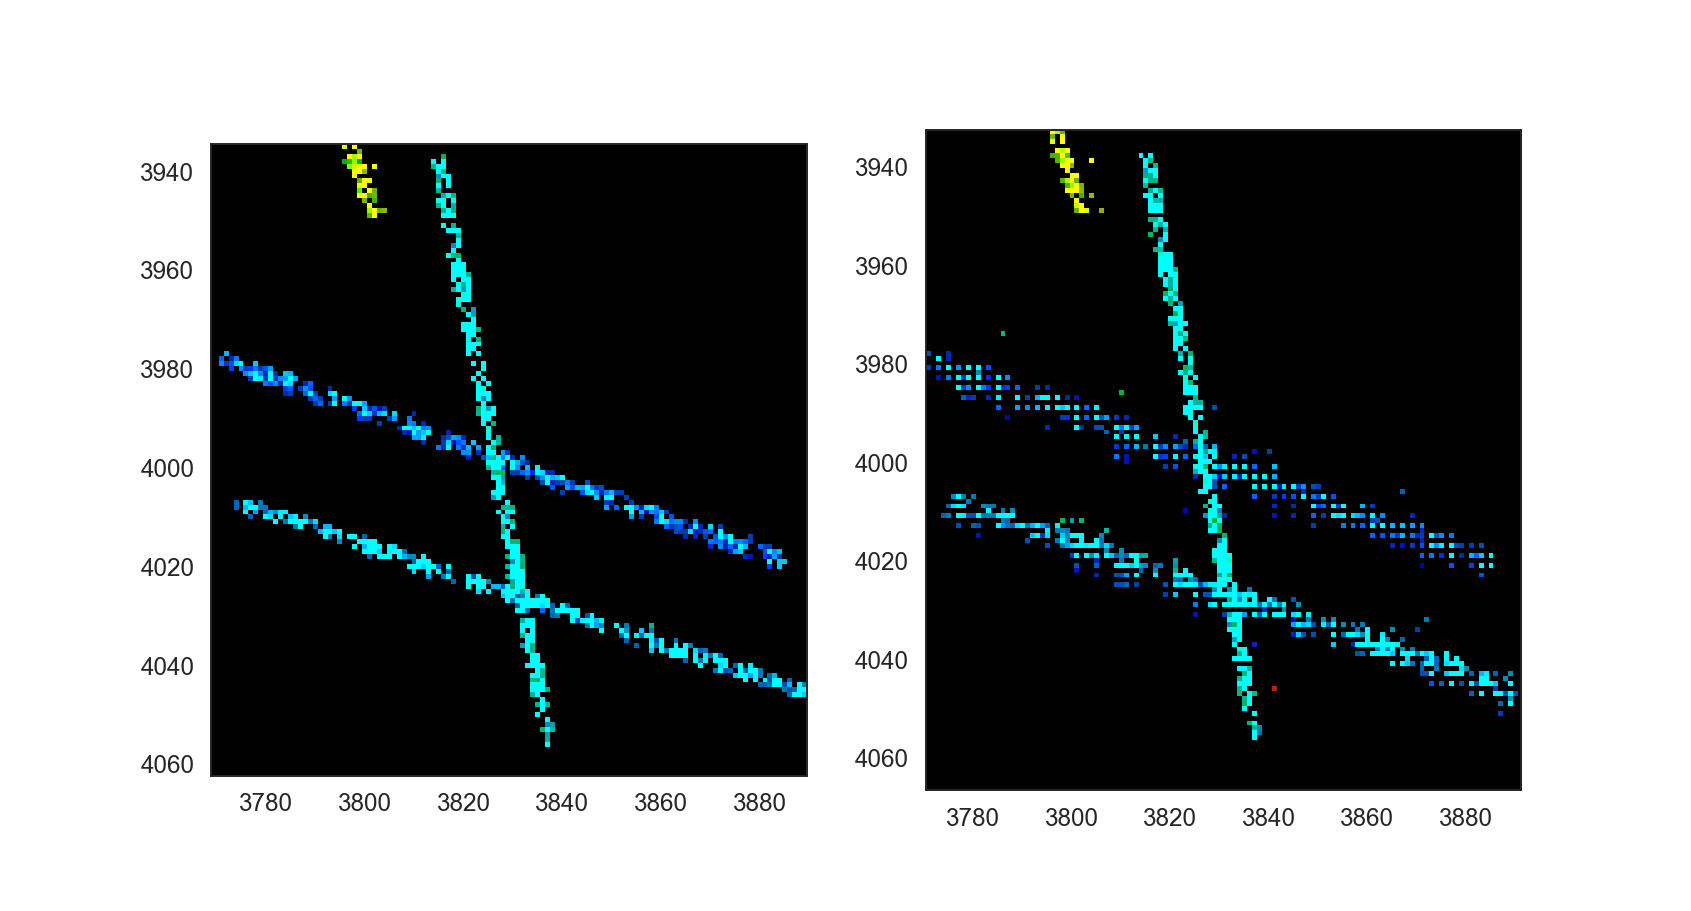

In [3]:
# We recommend using SMAP to postprocess the prediction list (drift correction, grouping, etc.) 
# and render the super-resolution image 
fd_deeploc_preds = read_csv(fd_deeploc_save_path).tolist()

decode_preds = read_csv(decode_save_path).tolist()

hist_img_fd_deeploc = create_3d_hist(fd_deeploc_preds, z_clip=[-700, 700], pix_size=50, sigma=5, contrast_fac=20)

hist_img_decode = create_3d_hist(decode_preds, z_clip=[-700, 700], pix_size=50, sigma=5, contrast_fac=20)

print('------------------------------------------compare the reconstructed image-------------------------------------------')
plt.figure()
plt.subplot(1,2,1)
plt.imshow(hist_img_fd_deeploc)
plt.subplot(1,2,2)
plt.imshow(hist_img_decode)